In [47]:
import pickle
from functools import partial
import itertools

import jax
import jax.numpy as np
from jax import random
from jax.scipy.linalg import block_diag
from tqdm import tqdm

from s5.dataloading import Datasets
from s5.seq_model import BatchClassificationModel, RetrievalModel
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.train_helpers import (create_train_state, reduce_lr_on_plateau, \
    linear_warmup, cosine_annealing, constant_lr, compute_accuracy, prep_batch, train_step, update_learning_rate_per_step, cross_entropy_loss)
from s5.gradients import gradient_monitoring_hook

In [48]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


# Create the args object
args = Args(
    ssm_size=128,
    jax_seed=0,
    blocks=1,
    d_model=64,
    n_layers=1,
    n_classes=2,
    C_init='complex_normal',
    discretization='zoh',
    dt_min=0.001,
    dt_max=0.1,
    conj_sym=True,
    clip_eigs=True,
    bidirectional=False,
    activation_fn='gelu',
    dropout=0.0,
    prenorm=True,
    batchnorm=False,
    bn_momentum=0.9,
    dir_name='./cache_dir',
    bsz=16,
    ssm_size_base=256,
    p_dropout=0.0,
    mode='pool',
    lr_factor=1,
    ssm_lr_base=1e-3,
    weight_decay=0.05,
    opt_config='standard',
    dt_global=False,
    dataset='mnist-classification',
    epochs=1,
    warmup_end=1,
    lr_min=0,
    reduce_factor=1.0,
    lr_patience=1000000
)

let's try to solve a simpler problem, just give me the hidden state at layer i at time t for a single batch.

In [49]:
def hidden_gradients(state,
               rng,
               batch_inputs,
               batch_integration_timesteps,
               model,
               batchnorm,
               ):
    """Computes gradients of hidden states with respect to parameters and inputs"""
    
    def hidden_fn(inputs, params):
        """Returns only the hidden states from the model"""
        if batchnorm:
            _, hiddens = model.apply(
                {"params": params, "batch_stats": state.batch_stats},
                inputs, batch_integration_timesteps,
                rngs={"dropout": rng},
                mutable=False  # We don't need to track batch stats anymore
            )
        else:
            _, hiddens = model.apply(
                {"params": params},
                inputs, batch_integration_timesteps,
                rngs={"dropout": rng},
                mutable=False,
            )
        return np.abs(hiddens)
    def hidden_at_time(inputs, params, time, dimension):
        """Returns the hidden state at a specific time and dimension"""
        hiddens = hidden_fn(inputs, params) # shape (bsz, time, hidden_dim)
        return np.mean(hiddens[:, time, dimension])
    gradient = jax.grad(hidden_at_time, argnums=0)(batch_inputs, state.params, 784//2, 0)
    return gradient.squeeze()


In [50]:
@partial(jax.jit, static_argnums=(5, 6))
def train_step_with_hiddens(state,
               rng,
               batch_inputs,
               batch_labels,
               batch_integration_timesteps,
               model,
               batchnorm,
               ):
    """Performs a single training step given a batch of data"""
    def loss_fn(params):

        if batchnorm:
            (logits, hiddens), mod_vars = model.apply(
                {"params": params, "batch_stats": state.batch_stats},
                batch_inputs, batch_integration_timesteps,
                rngs={"dropout": rng},
                mutable=["intermediates", "batch_stats"],
                capture_intermediates=True # probs don't need this anymore
            )
        else:
            (logits, hiddens), mod_vars = model.apply(
                {"params": params},
                batch_inputs, batch_integration_timesteps,
                rngs={"dropout": rng},
                mutable=["intermediates"], # probs don't need this anymore
            )

        loss = np.mean(cross_entropy_loss(logits, batch_labels))

        return loss, (mod_vars, logits)

    (loss, (mod_vars, logits)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    if batchnorm:
        state = state.apply_gradients(grads=grads, batch_stats=mod_vars["batch_stats"])
    else:
        state = state.apply_gradients(grads=grads)
    return state, loss

def train_epoch(state, rng, model, trainloader, seq_len, in_dim, batchnorm, lr_params):
    """
    Training function for an epoch that loops over batches.
    """
    # Store Metrics
    model = model(training=True)
    batch_losses = []
    gradients = []

    decay_function, ssm_lr, lr, step, end_step, opt_config, lr_min = lr_params

    for batch in tqdm(trainloader): # enumerate(itertools.islice(tqdm(trainloader), 10)):
        inputs, labels, integration_times = prep_batch(batch, seq_len, in_dim)
        rng, drop_rng = jax.random.split(rng)
        gradient = hidden_gradients(
            state=state,
            rng=rng,
            batch_inputs=inputs,
            batch_integration_timesteps=integration_times,
            model=model,
            batchnorm=batchnorm
        )
        gradients.append(gradient)
        state, loss = train_step_with_hiddens(
            state,
            drop_rng,
            inputs,
            labels,
            integration_times,
            model,
            batchnorm,
        )
        batch_losses.append(loss)
        lr_params = (decay_function, ssm_lr, lr, step, end_step, opt_config, lr_min)
        state, step = update_learning_rate_per_step(lr_params, state)

    # Return average loss over batches
    return state, np.mean(np.array(batch_losses)), step, np.array(gradients)

@partial(jax.jit, static_argnums=(4, 5))
def eval_step(batch_inputs,
              batch_labels,
              batch_integration_timesteps,
              state,
              model,
              batchnorm,
              ):
    if batchnorm:
        logits, hiddens = model.apply({"params": state.params, "batch_stats": state.batch_stats},
                             batch_inputs, batch_integration_timesteps,
                             )
    else:
        logits, hiddens = model.apply({"params": state.params},
                             batch_inputs, batch_integration_timesteps,
                             )

    losses = cross_entropy_loss(logits, batch_labels)
    accs = compute_accuracy(logits, batch_labels)

    return losses, accs, logits

def validate(state, model, testloader, seq_len, in_dim, batchnorm, step_rescale=1.0):
    """Validation function that loops over batches"""
    model = model(training=False, step_rescale=step_rescale)
    losses, accuracies, preds = np.array([]), np.array([]), np.array([])
    for batch_idx, batch in enumerate(tqdm(testloader)):
        inputs, labels, integration_timesteps = prep_batch(batch, seq_len, in_dim)
        loss, acc, pred = eval_step(inputs, labels, integration_timesteps, state, model, batchnorm)
        losses = np.append(losses, loss)
        accuracies = np.append(accuracies, acc)

    aveloss, aveaccu = np.mean(losses), np.mean(accuracies)
    return aveloss, aveaccu


def train(args):
    """
    Main function to train over a certain number of epochs
    """

    best_test_loss = 100000000
    best_test_acc = -10000.0
    

    ssm_size = args.ssm_size_base
    ssm_lr = args.ssm_lr_base

    # determine the size of initial blocks
    block_size = int(ssm_size / args.blocks)

    # Set global learning rate lr (e.g. encoders, etc.) as function of ssm_lr
    lr = args.lr_factor * ssm_lr

    # Set randomness...
    print("[*] Setting Randomness...")
    key = random.PRNGKey(args.jax_seed)
    init_rng, train_rng = random.split(key, num=2)

    # Get dataset creation function
    create_dataset_fn = Datasets[args.dataset]

    # Dataset dependent logic
    if args.dataset in ["imdb-classification", "listops-classification", "aan-classification"]:
        padded = True
        if args.dataset in ["aan-classification"]:
            # Use retreival model for document matching
            retrieval = True
            print("Using retrieval model for document matching")
        else:
            retrieval = False

    else:
        padded = False
        retrieval = False

    # For speech dataset
    if args.dataset in ["speech35-classification"]:
        speech = True
        print("Will evaluate on both resolutions for speech task")
    else:
        speech = False

    # Create dataset...
    init_rng, key = random.split(init_rng, num=2)
    trainloader, valloader, testloader, aux_dataloaders, n_classes, seq_len, in_dim, train_size = \
        create_dataset_fn(args.dir_name, seed=args.jax_seed, bsz=args.bsz)

    print(f"[*] Starting S5 Training on `{args.dataset}` =>> Initializing...")

    # Initialize state matrix A using approximation to HiPPO-LegS matrix
    Lambda, _, B, V, B_orig = make_DPLR_HiPPO(block_size)

    if args.conj_sym:
        block_size = block_size // 2
        ssm_size = ssm_size // 2

    Lambda = Lambda[:block_size]
    V = V[:, :block_size]
    Vc = V.conj().T

    # If initializing state matrix A as block-diagonal, put HiPPO approximation
    # on each block
    Lambda = (Lambda * np.ones((args.blocks, block_size))).ravel()
    V = block_diag(*([V] * args.blocks))
    Vinv = block_diag(*([Vc] * args.blocks))

    print("Lambda.shape={}".format(Lambda.shape))
    print("V.shape={}".format(V.shape))
    print("Vinv.shape={}".format(Vinv.shape))

    ssm_init_fn = init_S5SSM(H=args.d_model,
                             P=ssm_size,
                             Lambda_re_init=Lambda.real,
                             Lambda_im_init=Lambda.imag,
                             V=V,
                             Vinv=Vinv,
                             C_init=args.C_init,
                             discretization=args.discretization,
                             dt_min=args.dt_min,
                             dt_max=args.dt_max,
                             conj_sym=args.conj_sym,
                             clip_eigs=args.clip_eigs,
                             bidirectional=args.bidirectional)

    if retrieval:
        # Use retrieval head for AAN task
        print("Using Retrieval head for {} task".format(args.dataset))
        model_cls = partial(
            RetrievalModel,
            ssm=ssm_init_fn,
            d_output=n_classes,
            d_model=args.d_model,
            n_layers=args.n_layers,
            padded=padded,
            activation=args.activation_fn,
            dropout=args.p_dropout,
            prenorm=args.prenorm,
            batchnorm=args.batchnorm,
            bn_momentum=args.bn_momentum,
        )

    else:
        model_cls = partial(
            BatchClassificationModel,
            ssm=ssm_init_fn,
            d_output=n_classes,
            d_model=args.d_model,
            n_layers=args.n_layers,
            padded=padded,
            activation=args.activation_fn,
            dropout=args.p_dropout,
            mode=args.mode,
            prenorm=args.prenorm,
            batchnorm=args.batchnorm,
            bn_momentum=args.bn_momentum,
        )

    # initialize training state
    state = create_train_state(model_cls,
                               init_rng,
                               padded,
                               retrieval,
                               in_dim=in_dim,
                               bsz=args.bsz,
                               seq_len=seq_len,
                               weight_decay=args.weight_decay,
                               batchnorm=args.batchnorm,
                               opt_config=args.opt_config,
                               ssm_lr=ssm_lr,
                               lr=lr,
                               dt_global=args.dt_global)
    # print(state.)
    # Training Loop over epochs
    best_loss, best_acc, best_epoch = 100000000, -100000000.0, 0  # This best loss is val_loss
    count, best_val_loss = 0, 100000000  # This line is for early stopping purposes
    lr_count, opt_acc = 0, -100000000.0  # This line is for learning rate decay
    step = 0  # for per step learning rate decay
    steps_per_epoch = int(train_size/args.bsz)
    gradients_per_epoch = []
    for epoch in range(args.epochs):
        print(f"[*] Starting Training Epoch {epoch + 1}...")

        if epoch < args.warmup_end:
            print("using linear warmup for epoch {}".format(epoch + 1))
            decay_function = linear_warmup
            end_step = steps_per_epoch * args.warmup_end

        elif args.cosine_anneal:
            print("using cosine annealing for epoch {}".format(epoch + 1))
            decay_function = cosine_annealing
            # for per step learning rate decay
            end_step = steps_per_epoch * args.epochs - (steps_per_epoch * args.warmup_end)
        else:
            print("using constant lr for epoch {}".format(epoch + 1))
            decay_function = constant_lr
            end_step = None

        # TODO: Switch to letting Optax handle this.
        #  Passing this around to manually handle per step learning rate decay.
        lr_params = (decay_function, ssm_lr, lr, step, end_step, args.opt_config, args.lr_min)

        train_rng, skey = random.split(train_rng)
        state, train_loss, step, gradients = train_epoch(state,
                                              skey,
                                              model_cls,
                                              trainloader,
                                              seq_len,
                                              in_dim,
                                              args.batchnorm,
                                              lr_params)
        
        gradients_per_epoch.append(gradients)
        
        if valloader is not None:
            print(f"[*] Running Epoch {epoch + 1} Validation...")
            val_loss, val_acc = validate(state,
                                         model_cls,
                                         valloader,
                                         seq_len,
                                         in_dim,
                                         args.batchnorm)

            print(f"[*] Running Epoch {epoch + 1} Test...")
            test_loss, test_acc = validate(state,
                                           model_cls,
                                           testloader,
                                           seq_len,
                                           in_dim,
                                           args.batchnorm)

            print(f"\n=>> Epoch {epoch + 1} Metrics ===")
            print(
                f"\tTrain Loss: {train_loss:.5f} -- Val Loss: {val_loss:.5f} --Test Loss: {test_loss:.5f} --"
                f" Val Accuracy: {val_acc:.4f}"
                f" Test Accuracy: {test_acc:.4f}"
            )

        else:
            # else use test set as validation set (e.g. IMDB)
            print(f"[*] Running Epoch {epoch + 1} Test...")
            val_loss, val_acc = validate(state,
                                         model_cls,
                                         testloader,
                                         seq_len,
                                         in_dim,
                                         args.batchnorm)

            print(f"\n=>> Epoch {epoch + 1} Metrics ===")
            print(
                f"\tTrain Loss: {train_loss:.5f}  --Test Loss: {val_loss:.5f} --"
                f" Test Accuracy: {val_acc:.4f}"
            )

        # For early stopping purposes
        if val_loss < best_val_loss:
            count = 0
            best_val_loss = val_loss
        else:
            count += 1

        if val_acc > best_acc:
            # Increment counters etc.
            count = 0
            best_loss, best_acc, best_epoch = val_loss, val_acc, epoch
            if valloader is not None:
                best_test_loss, best_test_acc = test_loss, test_acc
            else:
                best_test_loss, best_test_acc = best_loss, best_acc

            # Do some validation on improvement.
            if speech:
                # Evaluate on resolution 2 val and test sets
                print(f"[*] Running Epoch {epoch + 1} Res 2 Validation...")
                val2_loss, val2_acc = validate(state,
                                               model_cls,
                                               aux_dataloaders['valloader2'],
                                               int(seq_len // 2),
                                               in_dim,
                                               args.batchnorm,
                                               step_rescale=2.0)

                print(f"[*] Running Epoch {epoch + 1} Res 2 Test...")
                test2_loss, test2_acc = validate(state, model_cls, aux_dataloaders['testloader2'], int(seq_len // 2), in_dim, args.batchnorm, step_rescale=2.0)
                print(f"\n=>> Epoch {epoch + 1} Res 2 Metrics ===")
                print(
                    f"\tVal2 Loss: {val2_loss:.5f} --Test2 Loss: {test2_loss:.5f} --"
                    f" Val Accuracy: {val2_acc:.4f}"
                    f" Test Accuracy: {test2_acc:.4f}"
                )

        # For learning rate decay purposes:
        input = lr, ssm_lr, lr_count, val_acc, opt_acc
        lr, ssm_lr, lr_count, opt_acc = reduce_lr_on_plateau(input, factor=args.reduce_factor, patience=args.lr_patience, lr_min=args.lr_min)

        # Print best accuracy & loss so far...
        print(
            f"\tBest Val Loss: {best_loss:.5f} -- Best Val Accuracy:"
            f" {best_acc:.4f} at Epoch {best_epoch + 1}\n"
            f"\tBest Test Loss: {best_test_loss:.5f} -- Best Test Accuracy:"
            f" {best_test_acc:.4f} at Epoch {best_epoch + 1}\n"
        )
    return gradients_per_epoch

In [51]:
grads = train(args)

[*] Setting Randomness...
[*] Generating MNIST Classification Dataset
[*] Starting S5 Training on `mnist-classification` =>> Initializing...
Lambda.shape=(128,)
V.shape=(256, 128)
Vinv.shape=(128, 256)
configuring standard optimization setup
[*] Trainable Parameters: 34122
[*] Starting Training Epoch 1...
using linear warmup for epoch 1


100%|██████████| 3375/3375 [21:21<00:00,  2.63it/s]


[*] Running Epoch 1 Validation...


100%|██████████| 375/375 [00:07<00:00, 50.82it/s]


[*] Running Epoch 1 Test...


100%|██████████| 625/625 [00:09<00:00, 62.78it/s]


=>> Epoch 1 Metrics ===
	Train Loss: 1.34174 -- Val Loss: 0.58187 --Test Loss: 0.54437 -- Val Accuracy: 0.8245 Test Accuracy: 0.8385
	Best Val Loss: 0.58187 -- Best Val Accuracy: 0.8245 at Epoch 1
	Best Test Loss: 0.54437 -- Best Test Accuracy: 0.8385 at Epoch 1



In [56]:
grads[0].shape

(3375, 16, 784)

(16, 784)


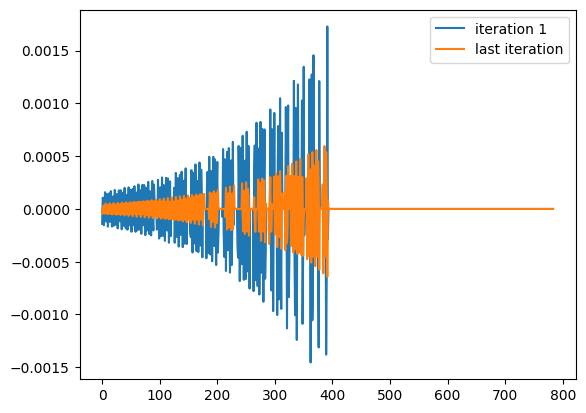

In [66]:
g0 = grads[0][0]
g1 = grads[0][-1]
print(g0.shape)

import matplotlib.pyplot as plt

plt.plot(g0[0], label='iteration 1')
plt.plot(g1[0], label='last iteration')
plt.legend()
plt.show()

In [59]:
np.save('./gradients.npy', grads[0])

In [60]:
pickle.dump(grads, open('./gradients.pkl', 'wb'))